In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [0]:
 # Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.8 #@param {type:"number"}
LEARNING_RATE = 9.0 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=32, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(64, pool, res = True)
    self.blk2 = ResBlk(96, pool)
    self.blk3 = ResBlk(128, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
!cp '/content/drive/My Drive/img_aug_cutout_x.npy' .
!cp '/content/drive/My Drive/lables_cutout.npy' .



In [0]:
augmented_x_files = ['img_aug_cutout_x.npy', 'img_aug_cutout_x.npy', 'img_aug_cutout_x.npy','img_aug_cutout_x.npy', 'img_aug_cutout_x.npy', 'img_aug_cutout_x.npy',
                     'img_aug_cutout_x.npy', 'img_aug_cutout_x.npy', 'img_aug_cutout_x.npy','img_aug_cutout_x.npy', 'img_aug_cutout_x.npy', 'img_aug_cutout_x.npy']


augmented_y_files = ['lables_cutout.npy','lables_cutout.npy','lables_cutout.npy','lables_cutout.npy','lables_cutout.npy','lables_cutout.npy',
                    'lables_cutout.npy','lables_cutout.npy','lables_cutout.npy','lables_cutout.npy','lables_cutout.npy','lables_cutout.npy']

combined_x_aug = None
combined_y_aug = None

In [0]:
for x_file_name in augmented_x_files[:2]:
    aug_x = np.load(x_file_name, encoding='latin1')
    if combined_x_aug is None:
        combined_x_aug = aug_x
    else:
        combined_x_aug = np.append(combined_x_aug, aug_x, axis=0)
    
for y_file_name in augmented_y_files[:2]:
    if combined_y_aug is None:
        aug_y = np.load(y_file_name, encoding='latin1')
    else:
        combined_y_aug = np.append(combined_y_aug, aug_y, axis=0)       
    

In [0]:
combined_x_aug.shape

(100000, 32, 32, 3)

In [0]:
import numpy as np
#from random import shuffle


#ind_list = [i for i in range(combined_x_aug.shape[0])]

ind_list = np.random.rand(100000).argsort()
#permutation(ind_list)
#shuffle(ind_list)

#combined_x_aug  = combined_x_aug[ind_list, :,:,:]
print(ind_list)






[47984 56839 70391 ...  8649 71406 71368]


In [0]:
combined_x_aug  = combined_x_aug[ind_list]

In [0]:
combined_x_aug.shape

(100000, 32, 32, 3)

In [0]:
aug_x.shape

(50000, 32, 32, 3)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

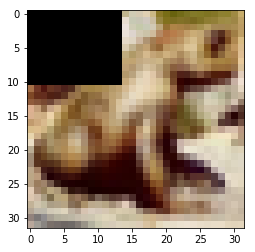

In [0]:
img = combined_x_aug[1]   
plt.imshow(img)

In [0]:
aug_y = np.load('lables_cutout.npy', encoding='latin1')

In [0]:
aug_y[1]

2

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)



170500096/170498071 [==============================] - 6s 0us/step


In [0]:
x_train = np.append(x_train, aug_x, axis=0)


In [0]:
y_train = np.append(y_train, aug_y, axis=0)

In [0]:
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [0]:
x_train.shape

(100000, 40, 40, 3)

In [0]:
y_train.shape

(100000,)

In [0]:
len_train = len(x_train)

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [0]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.8 train loss: 1.3455468788146974 train acc: 0.51052 val loss: 1.13646630859375 val acc: 0.6346 time: 66.08060455322266



epoch: 2 lr: 1.6 train loss: 0.765205982131958 train acc: 0.72896 val loss: 1.4588310760498047 val acc: 0.5953 time: 126.38779854774475



epoch: 3 lr: 2.4000000000000004 train loss: 0.6514015127563476 train acc: 0.77289 val loss: 0.9909272766113282 val acc: 0.7116 time: 186.79590034484863



epoch: 4 lr: 3.2 train loss: 0.6135545907592773 train acc: 0.78786 val loss: 1.2903160369873048 val acc: 0.6562 time: 247.18715286254883



epoch: 5 lr: 4.0 train loss: 0.5982934301757813 train acc: 0.79644 val loss: 0.7211880416870117 val acc: 0.781 time: 307.59741497039795



epoch: 6 lr: 3.7894736842105265 train loss: 0.5464386373901368 train acc: 0.81254 val loss: 0.7949018798828125 val acc: 0.7734 time: 367.98828506469727



epoch: 7 lr: 3.5789473684210527 train loss: 0.4716047988128662 train acc: 0.83788 val loss: 0.5879745971679687 val acc: 0.8153 time: 428.32960414886475



epoch: 8 lr: 3.3684210526315788 train loss: 0.42290316192626953 train acc: 0.85354 val loss: 0.44552176818847655 val acc: 0.8531 time: 488.750825881958



epoch: 9 lr: 3.1578947368421053 train loss: 0.3884462589263916 train acc: 0.86602 val loss: 0.5281477661132813 val acc: 0.832 time: 548.7837960720062



epoch: 10 lr: 2.947368421052632 train loss: 0.3514039279556274 train acc: 0.8771 val loss: 0.3981270477294922 val acc: 0.8766 time: 609.0737640857697



epoch: 11 lr: 2.736842105263158 train loss: 0.32936267639160155 train acc: 0.88473 val loss: 0.46790652770996094 val acc: 0.865 time: 669.5066659450531



epoch: 12 lr: 2.526315789473684 train loss: 0.30180350234985354 train acc: 0.89422 val loss: 0.41026528930664063 val acc: 0.8744 time: 729.523111820221



epoch: 13 lr: 2.3157894736842106 train loss: 0.28024261825561525 train acc: 0.90136 val loss: 0.39149063186645505 val acc: 0.8802 time: 789.53005027771



epoch: 14 lr: 2.105263157894737 train loss: 0.26174236206054685 train acc: 0.9073 val loss: 0.3722918769836426 val acc: 0.8878 time: 849.6981964111328



epoch: 15 lr: 1.8947368421052633 train loss: 0.24316686038970947 train acc: 0.91423 val loss: 0.38135384674072265 val acc: 0.8828 time: 910.1892857551575



epoch: 16 lr: 1.6842105263157894 train loss: 0.22514935768127442 train acc: 0.92024 val loss: 0.3250937355041504 val acc: 0.8997 time: 970.4249699115753



epoch: 17 lr: 1.473684210526316 train loss: 0.2097582453727722 train acc: 0.92549 val loss: 0.3188410652160645 val acc: 0.9044 time: 1030.5644195079803



epoch: 18 lr: 1.2631578947368425 train loss: 0.19322364933013916 train acc: 0.93205 val loss: 0.3309551383972168 val acc: 0.9007 time: 1090.7020750045776



epoch: 19 lr: 1.0526315789473686 train loss: 0.1779755574798584 train acc: 0.93635 val loss: 0.32297556381225584 val acc: 0.9063 time: 1150.8410775661469



epoch: 20 lr: 0.8421052631578947 train loss: 0.16747371601104735 train acc: 0.94 val loss: 0.3234566856384277 val acc: 0.9058 time: 1211.3136575222015



epoch: 21 lr: 0.6315789473684212 train loss: 0.15441998359680176 train acc: 0.94576 val loss: 0.31059376525878907 val acc: 0.9094 time: 1271.4682080745697



epoch: 22 lr: 0.4210526315789478 train loss: 0.1389230534362793 train acc: 0.95089 val loss: 0.30082122497558594 val acc: 0.9137 time: 1331.7146801948547



epoch: 23 lr: 0.2105263157894739 train loss: 0.12866029010772706 train acc: 0.95442 val loss: 0.29984465026855467 val acc: 0.9152 time: 1392.0364797115326



epoch: 24 lr: 0.0 train loss: 0.12071522064208984 train acc: 0.95776 val loss: 0.29606649780273436 val acc: 0.9163 time: 1452.0521938800812
